# Step 10 - Geodesic distances 

In [1]:
# These lines are necessary only if GemPy is not installed
import sys, os
sys.path.append("../../..")
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['MKL_THREADING_LAYER'] = 'GNU'

# Importing GemPy, which takes really long
import gempy as gp

# Importing auxiliary libraries
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
import pandas as pd

from scipy import sparse
from scipy.sparse.linalg import splu
#from util import veclen, normalized

from skimage import measure
from scipy.spatial.distance import cdist

C:\Users\Jan\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Importing the data from CSV-files and setting extent and resolution, example without faults
geo_data = gp.create_data([0,3000,0,200,0,2000],resolution=[120,4,80], 
                         path_o = "C:/Users/Jan/gempy/notebooks/input_data/tut_chapter3/tutorial_ch3_foliations", # importing orientation (foliation) data
                         path_i = "C:/Users/Jan/gempy/notebooks/input_data/tut_chapter3/tutorial_ch3_interfaces") # importing point-positional interface data

C:\Users\Jan\Anaconda3\lib\site-packages\pandas\core\frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [3]:
interp_data = gp.InterpolatorData(geo_data, u_grade=[1], output='geology', compile_theano=True,
                                  theano_optimizer='fast_compile')

interp_data_grad = gp.InterpolatorData(geo_data, u_grade=[1], output='gradients', compile_theano=True,
                                  theano_optimizer='fast_compile')

Compiling theano function...


WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


Compilation Done!
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float32
Number of faults:  0
Compiling theano function...
Compilation Done!
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float32
Number of faults:  0


In [4]:
lith_block, fault_block = gp.compute_model(interp_data)

In [5]:
def init_domain (geomodel, grid, formation):
        """
        Method to create a new pandas dataframe containing a grid for the SGS. Grid from complete geologic model is
        down to a certain formation of interest.
        Args:
            geomodel (numpy.ndarray): lithological block model created with gempy
            grid (gempy.data_management.GridClass): Grid created for geologic model
            formation (int): Number of formation to perform CoKriging on
        Returns:
            pandas.dataframe: Dataframe with all relevant data for grid, cut to one lith
        """
    
        # convert lith block values to int, thats what Miguel suggested
        lith_block_int = np.round(lith_block)
    
        # create the dataframe and populate with data
        d = {'X': grid.values[:,0], 'Y': grid.values[:,1], 'Z': grid.values[:,2], 'lith': lith_block_int[0], 'grad': lith_block[1]}
        df_cokr = pd.DataFrame(data=d)

        # cut down to wanted lithology and reset dataframne
        df_sgs_grid = df_cokr.loc[df_cokr['lith'] == formation]
        df_sgs_grid = df_sgs_grid.reset_index() # reset indicies
        del df_sgs_grid['index'] # reset indices

        return df_sgs_grid

In [6]:
def veclen(vectors):
    """ return L2 norm (vector length) along the last axis, for example to compute the length of an array of vectors """
    return np.sqrt(np.sum(vectors**2, axis=-1))

def normalized(vectors):
    """ normalize array of vectors along the last axis """
    return vectors / veclen(vectors)[..., np.newaxis]


def compute_mesh_laplacian(verts, tris):
    """
    computes a sparse matrix representing the discretized laplace-beltrami operator of the mesh
    given by n vertex positions ("verts") and a m triangles ("tris") 
    
    verts: (n, 3) array (float)
    tris: (m, 3) array (int) - indices into the verts array
    computes the conformal weights ("cotangent weights") for the mesh, ie:
    w_ij = - .5 * (cot \alpha + cot \beta)
    See:
        Olga Sorkine, "Laplacian Mesh Processing"
        and for theoretical comparison of different discretizations, see 
        Max Wardetzky et al., "Discrete Laplace operators: No free lunch"
    returns matrix L that computes the laplacian coordinates, e.g. L * x = delta
    """
    n = len(verts)
    W_ij = np.empty(0)
    I = np.empty(0, np.int32)
    J = np.empty(0, np.int32)
    for i1, i2, i3 in [(0, 1, 2), (1, 2, 0), (2, 0, 1)]: # for edge i2 --> i3 facing vertex i1
        vi1 = tris[:,i1] # vertex index of i1
        vi2 = tris[:,i2]
        vi3 = tris[:,i3]
        # vertex vi1 faces the edge between vi2--vi3
        # compute the angle at v1
        # add cotangent angle at v1 to opposite edge v2--v3
        # the cotangent weights are symmetric
        u = verts[vi2] - verts[vi1]
        v = verts[vi3] - verts[vi1]
        cotan = (u * v).sum(axis=1) / veclen(np.cross(u, v))
        W_ij = np.append(W_ij, 0.5 * cotan)
        I = np.append(I, vi2)
        J = np.append(J, vi3)
        W_ij = np.append(W_ij, 0.5 * cotan)
        I = np.append(I, vi3)
        J = np.append(J, vi2)
    L = sparse.csr_matrix((W_ij, (I, J)), shape=(n, n))
    # compute diagonal entries
    L = L - sparse.spdiags(L * np.ones(n), 0, n, n)
    L = L.tocsr()
    # area matrix
    e1 = verts[tris[:,1]] - verts[tris[:,0]]
    e2 = verts[tris[:,2]] - verts[tris[:,0]]
    n = np.cross(e1, e2)
    triangle_area = .5 * veclen(n)
    # compute per-vertex area
    vertex_area = np.zeros(len(verts))
    ta3 = triangle_area / 3
    for i in range(tris.shape[1]): # Jan: changed xrange to range
        bc = np.bincount(tris[:,i].astype(int), ta3)
        vertex_area[:len(bc)] += bc
    VA = sparse.spdiags(vertex_area, 0, len(verts), len(verts))
    return L, VA


class GeodesicDistanceComputation(object):
    """ 
    Computation of geodesic distances on triangle meshes using the heat method from the impressive paper
        Geodesics in Heat: A New Approach to Computing Distance Based on Heat Flow
        Keenan Crane, Clarisse Weischedel, Max Wardetzky
        ACM Transactions on Graphics (SIGGRAPH 2013)
    Example usage:
        >>> compute_distance = GeodesicDistanceComputation(vertices, triangles)
        >>> distance_of_each_vertex_to_vertex_0 = compute_distance(0)
    """

    def __init__(self, verts, tris, m=10.0):
        self._verts = verts
        self._tris = tris
        # precompute some stuff needed later on
        e01 = verts[tris[:,1]] - verts[tris[:,0]]
        e12 = verts[tris[:,2]] - verts[tris[:,1]]
        e20 = verts[tris[:,0]] - verts[tris[:,2]]
        self._triangle_area = .5 * veclen(np.cross(e01, e12))
        unit_normal = normalized(np.cross(normalized(e01), normalized(e12)))
        self._unit_normal_cross_e01 = np.cross(unit_normal, e01)
        self._unit_normal_cross_e12 = np.cross(unit_normal, e12)
        self._unit_normal_cross_e20 = np.cross(unit_normal, e20)
        # parameters for heat method
        h = np.mean(list(map(veclen, [e01, e12, e20]))) # Jan: converted to list
        t = m * h ** 2
        # pre-factorize poisson systems
        Lc, A = compute_mesh_laplacian(verts, tris)
        self._factored_AtLc = splu((A - t * Lc).tocsc()).solve
        self._factored_L = splu(Lc.tocsc()).solve

    def __call__(self, idx):
        """ 
        computes geodesic distances to all vertices in the mesh
        idx can be either an integer (single vertex index) or a list of vertex indices
        or an array of bools of length n (with n the number of vertices in the mesh) 
        """
        u0 = np.zeros(len(self._verts))
        u0[idx] = 1.0
        # heat method, step 1
        u = self._factored_AtLc(u0).ravel()
        # heat method step 2
        grad_u = 1 / (2 * self._triangle_area)[:,np.newaxis] * (
              self._unit_normal_cross_e01 * u[self._tris[:,2]][:,np.newaxis]
            + self._unit_normal_cross_e12 * u[self._tris[:,0]][:,np.newaxis]
            + self._unit_normal_cross_e20 * u[self._tris[:,1]][:,np.newaxis]
        )
        X = - grad_u / veclen(grad_u)[:,np.newaxis]
        # heat method step 3
        div_Xs = np.zeros(len(self._verts))
        for i1, i2, i3 in [(0, 1, 2), (1, 2, 0), (2, 0, 1)]: # for edge i2 --> i3 facing vertex i1
            vi1, vi2, vi3 = self._tris[:,i1], self._tris[:,i2], self._tris[:,i3]
            e1 = self._verts[vi2] - self._verts[vi1]
            e2 = self._verts[vi3] - self._verts[vi1]
            e_opp = self._verts[vi3] - self._verts[vi2]
            cot1 = 1 / np.tan(np.arccos( 
                (normalized(-e2) * normalized(-e_opp)).sum(axis=1)))
            cot2 = 1 / np.tan(np.arccos(
                (normalized(-e1) * normalized( e_opp)).sum(axis=1)))
            div_Xs += np.bincount(
                vi1.astype(int), 
        0.5 * (cot1 * (e1 * X).sum(axis=1) + cot2 * (e2 * X).sum(axis=1)), 
        minlength=len(self._verts))
        phi = self._factored_L(div_Xs).ravel()
        phi -= phi.min()
        return phi

In [27]:
# create domain data for certain lithology
domain_data = init_domain(lith_block, geo_data.grid, formation=3)

# set test points
rand_ind1 = np.random.randint(1, 3760) # proof for mistake = 2895
rand_ind2 = np.random.randint(1, 3760)

pointA = np.array([[domain_data.X[rand_ind1], domain_data.Y[rand_ind1], domain_data.Z[rand_ind1]]])
pointB = np.array([[domain_data.X[rand_ind2], domain_data.Y[rand_ind2], domain_data.Z[rand_ind2]]])

In [28]:
def closest_node(node, nodes):
        closest_ind = cdist(node, nodes).argmin()
        dist = cdist(node, nodes)[0][closest_ind] # problem: distance very far and variable - not viable
        # print(dist)
        return closest_ind

In [80]:
def perpendicular_dist(start_point, grad_val1, grad_val2, interp_data_grad):
    
    step_size = 1 # length of vector
    step = 0
    a = start_point
    print(step)
    
    if grad_val1 < grad_val2:
        print("loop to bigger")
        for i in range (1000):
            # calculate scalar field vector at point
            grad_vec = gp.compute_model_at(pointA, interp_data_grad)
            grad_vec =np.array([grad_vec[0][2],grad_vec[0][3],grad_vec[0][4]])
            
            # normalize to step size and set direction
            vec_len = np.linalg.norm((grad_vec), ord=1)
            grad_vec_norm = step_size*grad_vec/vec_len
            grad_vec_norm = np.reshape(grad_vec_norm, (1, 3))
            
            a = a+grad_vec_norm
            
            if gp.compute_model_at(a, interp_data)[0][1] > grad_val2:
                break
    
            step += 1
            
    else:
        print("loop to smaller")
        for i in range (1000):
            # calculate scalar field vector at point
            grad_vec = gp.compute_model_at(pointA, interp_data_grad)
            grad_vec =np.array([grad_vec[0][2],grad_vec[0][3],grad_vec[0][4]])
            
            # normalize to step size and set direction
            vec_len = np.linalg.norm((grad_vec), ord=1)
            grad_vec_norm = step_size*grad_vec/vec_len
            grad_vec_norm = np.reshape(grad_vec_norm, (1, 3))
            grad_vec_norm = grad_vec_norm*(-1)
            
            a = a+grad_vec_norm
            
            if gp.compute_model_at(a, interp_data)[0][1] < grad_val2:
                break
    
            step += 1
    
    print(step)
    dist = step*step_size
    point = a
    
    return dist, point


In [81]:
def parallel_dist(vertices, simplices, point1, point2):
    
    compute_distance = GeodesicDistanceComputation(vertices, simplices)
    
    distance_of_each_vertex_to_vertex_0 = compute_distance(point1)
    
    dist = distance_of_each_vertex_to_vertex_0[point2]
    
    return dist

In [103]:
def get_distance(pointA, pointB, geo_data, interp_data, interp_data_grad):

    # get resolution of orginal grid and reshape the gradients accordingly
    res = gp.get_resolution(geo_data)
    a = lith_block[1].reshape(res)
    
    # get gradient value 
    gradA = gp.compute_model_at(pointA, interp_data)
    gradB = gp.compute_model_at(pointB, interp_data)
    
    # get two mesh planes, one for each point
    # I need to checl why step size 2 works but one doesnt
    vertices_pA, simplices_pA, normalsA, valuesA = measure.marching_cubes_lewiner(
            a,
            gradA[0][1],
            step_size=1,
            spacing=((geo_data.extent[1]/geo_data.resolution[0]),(geo_data.extent[3]/geo_data.resolution[1]),(geo_data.extent[5]/geo_data.resolution[2])))
    
    vertices_pB, simplices_pB, normalsB, valuesB = measure.marching_cubes_lewiner(
            a,
            gradB[0][1],
            step_size=1,
            spacing=((geo_data.extent[1]/geo_data.resolution[0]),(geo_data.extent[3]/geo_data.resolution[1]),(geo_data.extent[5]/geo_data.resolution[2])))
    
    
    # select closest points in mesh
    closeA = closest_node(pointA, vertices_pA)
    closeB = closest_node(pointB, vertices_pB)

    
    # calculate perpendicular distance towards each triangular mesh respectively
    dist_perpA, pointA2 = perpendicular_dist(pointA, gradA[0][1], gradB[0][1], interp_data_grad)
    dist_perpB, pointB2 = perpendicular_dist(pointB, gradB[0][1], gradA[0][1], interp_data_grad)
    closeA2 = closest_node(pointA2, vertices_pB)
    closeB2 = closest_node(pointB2, vertices_pA)
    
    # calculate parallel distance
    dist_paraA = parallel_dist(vertices_pA, simplices_pA, closeA, closeB2)
    dist_paraB = parallel_dist(vertices_pB, simplices_pB, closeB, closeA2)
    
    # calculate full distance
    dist = 0.5*(dist_paraA+dist_paraB)+0.5*(dist_perpA+dist_perpB)

    print(dist)
    
    return vertices_pA, simplices_pA, vertices_pB, simplices_pB, closeA, closeB, dist

In [104]:
vertices1, simplices1, vertices2, simplices2, closeA, closeB, dist_result = get_distance(pointA, pointB, geo_data, interp_data, interp_data_grad)

0
loop to bigger
54
0
loop to smaller
54


RuntimeError: Factor is exactly singular

In [91]:
ver , sim = gp.get_surfaces(interp_data, lith_block[1])

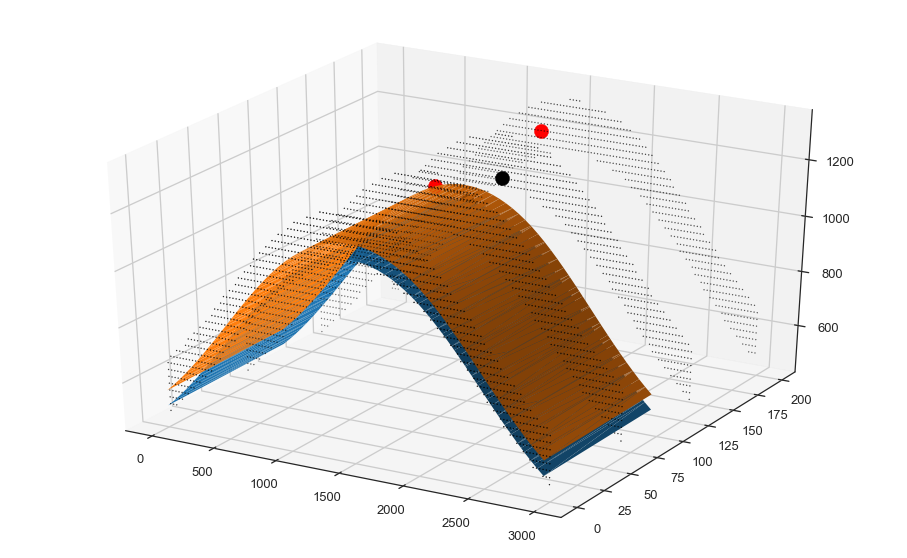

In [92]:
fig = plt.figure(figsize=(16,10))
# Plot the surface.  The triangles in parameter space determine which x, y, z
# points are connected by an edge.

ax = fig.add_subplot(1, 1, 1, projection='3d')

#ax.plot_trisurf(ver[1][:,0], ver[1][:,1], ver[1][:,2], triangles=sim[1])
#ax.plot_trisurf(ver[2][:,0], ver[2][:,1], ver[2][:,2], triangles=sim[2])

ax.scatter3D(xs=pointA[0][0], ys=pointA[0][1], zs=pointA[0][2], s=200, c='black')
ax.scatter3D(xs=pointB[0][0], ys=pointB[0][1], zs=pointB[0][2], s=200, c='red')
ax.scatter3D(xs=domain_data.X, ys=domain_data.Y, zs=domain_data.Z, s=1, c='black')

ax.plot_trisurf(vertices1[:,0], vertices1[:,1], vertices1[:,2], triangles=simplices1)
ax.plot_trisurf(vertices2[:,0], vertices2[:,1], vertices2[:,2], triangles=simplices2)

ax.scatter3D(xs=vertices1[closeA,0], ys=vertices1[closeA,1], zs=vertices1[closeA,2], s=200, c='black')
ax.scatter3D(xs=vertices2[closeB,0], ys=vertices2[closeB,1], zs=vertices2[closeB,2], s=200, c='red')

# trying to plot arrows
#soa = np.array([[vertices1[closeA,0], vertices1[closeA,1], vertices1[closeA,2], grad[0][2]*100, grad[0][3]*100, grad[0][4]*100]])

#X, Y, Z, U, V, W = zip(*soa)
#ax.quiver(X, Y, Z, U, V, W)

In [37]:
# following part is just for testing the geodesic distance algorithm

print(sim[1].shape)
print(ver[1].shape)

(1078, 3)
(713, 3)


In [38]:
compute_distance = GeodesicDistanceComputation(ver[1], sim[1])

In [39]:
point = 500

In [40]:
distance_of_each_vertex_to_vertex_0 = compute_distance(point)

In [41]:
distance_of_each_vertex_to_vertex_0[500]

0.0

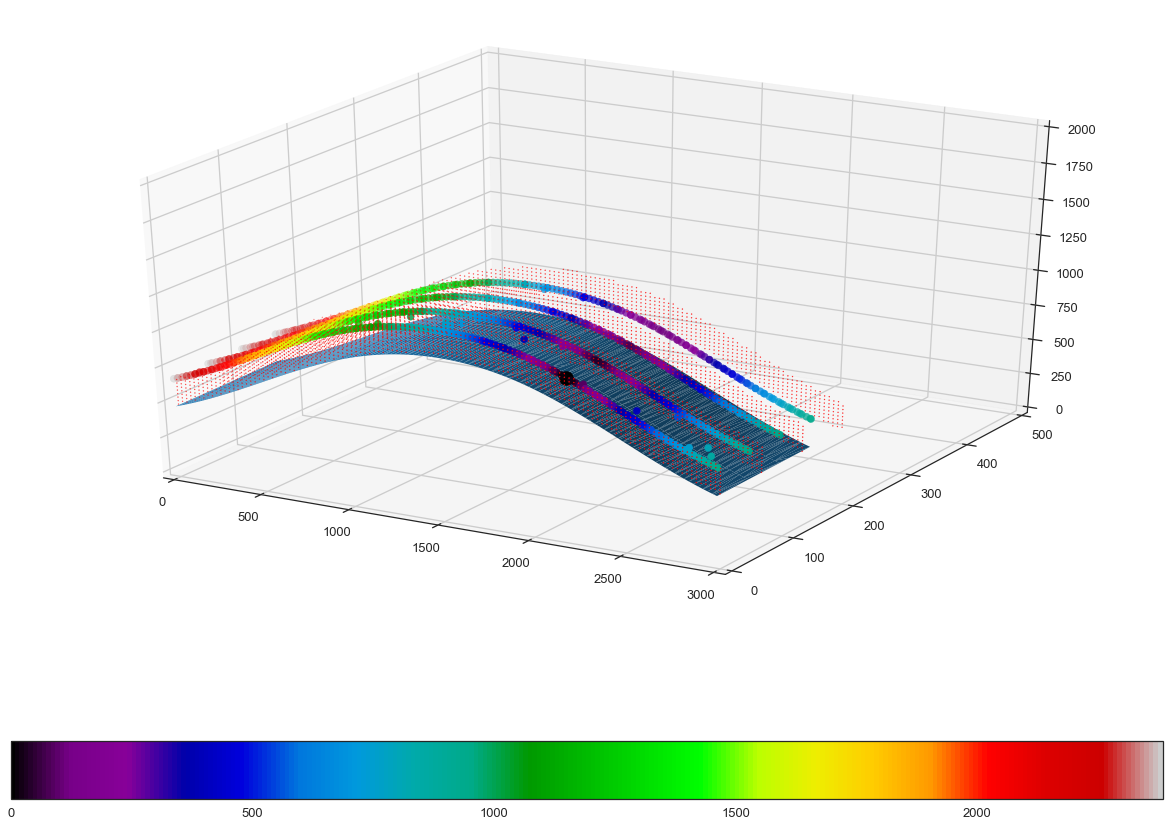

In [42]:
fig = plt.figure(figsize=(16,12))
ax = Axes3D(fig)
ax.axes.set_zlim3d(0,2000)
ax.axes.set_xlim3d(0,3000)
ax.axes.set_ylim3d(0,500)
a = ax.scatter3D(xs=ver[1][:,0],ys=ver[1][:,1],zs=ver[1][:,2], c=distance_of_each_vertex_to_vertex_0, cmap='nipy_spectral', s=50)
# a = ax.scatter3D(xs=ver[2][:,0],ys=ver[2][:,1],zs=ver[2][:,2], c='black', cmap='nipy_spectral', s=50)
b = ax.scatter3D(xs=ver[1][point][0],ys=ver[1][point][1],zs=ver[1][point][2], c='black', s=200)
c = ax.scatter3D(xs=domain_data.X,ys=domain_data.Y,zs=domain_data.Z, c='red', s=1)
#d = ax.plot_trisurf(ver[1][:,0], ver[1][:,1], ver[1][:,2], triangles=sim[2])
e = ax.plot_trisurf(ver[2][:,0], ver[2][:,1], ver[2][:,2], triangles=sim[2])


fig.colorbar(a, orientation='horizontal')

In [105]:
# get resolution of orginal grid and reshape the gradients accordingly
res = gp.get_resolution(geo_data)
a = lith_block[1].reshape(res)
    
# get gradient value 
gradA = gp.compute_model_at(pointA, interp_data)
gradB = gp.compute_model_at(pointB, interp_data)

vertices_test, simplices_test, normalsA, valuesA = measure.marching_cubes_lewiner(
            a,
            gradA[0][1],
            step_size=1,
            spacing=((geo_data.extent[1]/geo_data.resolution[0]),(geo_data.extent[3]/geo_data.resolution[1]),(geo_data.extent[5]/geo_data.resolution[2])))

In [106]:
compute_distance = GeodesicDistanceComputation(vertices_test, simplices_test)

RuntimeError: Factor is exactly singular